In [22]:
# ============================================================
# 017 aggregate_visualize_weekly
# ============================================================
#
# Overview
# --------
# This notebook aggregates weekly NewsAPI article data for a fixed set of 15 B Capital–oriented
# keywords (AI/Robotics, Healthtech, Climate, Deeptech) and produces time-series metrics and
# visual outputs for weekly trend monitoring.
#
# The goal is to convert raw article-level records into (1) normalized weekly keyword signals
# and (2) standardized plots that make it easy to spot rising topics, cooling topics, and
# category-level shifts over time.
#
# Inputs / Outputs
# ----------------
# Inputs:
# - Keyword dictionary (CSV)
#   - Location (default): notebooks/keywords/bcapital_15_keywords.csv
#   - Required columns:
#     - keyword_id: stable identifier (slug)
#     - canonical: display name
#     - category: one of {AI_Robotics, Healthtech, Climate, Deeptech}
#     - query: the NewsAPI query used during fetch (for reproducibility)
# - Raw NewsAPI weekly snapshots (Parquet + JSON)
#   - Location pattern: notebooks/data/raw/newsapi/YYYY-WW/
#   - Files:
#     - articles.parquet
#     - keyword_hits.parquet (optional; may mirror articles.parquet row granularity)
#     - metadata.json (optional)
#   - Expected fields (minimum, articles.parquet):
#     - week_label (e.g., "2025-W52")
#     - publishedAt (ISO 8601 timestamp)
#     - publishedAt_dt (derived, UTC)
#     - keyword_id
#     - canonical (may exist in raw; dictionary is source of truth)
#     - category (may exist in raw; dictionary is source of truth)
#     - url, url_key (url_key used for deduplication)
#     - source_name
#     - title, description
#     - fetched_at_utc
#
# Outputs:
# - Curated weekly metrics (Parquet)
#   - keyword_weekly metrics:
#     - week_start (Monday 00:00 UTC; derived from publishedAt_dt using ISO week)
#     - iso_week_label (e.g., "2025-W52")
#     - keyword_id, canonical, category
#     - hits (weekly deduplicated article count per keyword; dedup by url_key)
#     - total_articles (weekly deduplicated corpus size; dedup by url_key)
#     - share (hits / total_articles)
#     - optional: rolling means, WoW deltas, z-score
#   - category_weekly metrics:
#     - week_start, iso_week_label, category
#     - category_hits / category_share
# - Figures (PNG) saved under: notebooks/out/figures/
#   - Category trends
#   - Keyword comparison
#   - Deeptech focus
#   - Heatmap (keyword × week)
# - Weekly insight stub (table)
#   - Latest-week ranking by share / z-score / WoW delta
#
# Structure
# ---------
# Cell 0  - Purpose / Inputs / Outputs (this section)
# Cell 1  - Imports & Plot Config
# Cell 2  - Load Keyword Dictionary
# Cell 3  - Load Raw Articles
# Cell 4  - Build Time Buckets
# Cell 5  - Compute Metrics
# Cell 6  - Optional Metrics
# Cell 7  - Save Curated Metrics
# Cell 8  - Plot 1: Category Trends
# Cell 9  - Plot 2: Keyword Comparison
# Cell 10 - Plot 3: Deeptech Focus
# Cell 11 - Plot 4: Heatmap (keyword × week)
# Cell 12 - Save Figures (file naming rules)
# Cell 13 - Weekly Insight Stub (Markdown or table)
#
# Notes
# -----
# - Weekly operation assumption:
#   - This notebook is designed to run after the weekly fetch notebook has produced new raw
#     files for the latest completed week. It can also be re-run over a larger historical
#     window to rebuild metrics and figures deterministically.
# - Normalization is critical:
#   - Use share = hits / total_articles to reduce bias from week-to-week changes in overall
#     news volume and source coverage.
# - Deduplication:
#   - URL-level deduplication should be applied before counting hits to avoid inflating counts
#     due to repeated ingestion of the same article.
# - Reproducibility:
#   - Keep the keyword dictionary versioned in-repo, and store raw snapshots by ISO week so
#     results can be reproduced later.
# - Keyword dictionary bootstrap:
#   - If the keyword dictionary CSV does not exist, the notebook can create a default
#     15-keyword dictionary and save it under notebooks/keywords/ for future runs.


In [2]:
# ============================================================
# Cell 1 — Imports & Plot Config
# ============================================================

from __future__ import annotations

import os
import json
from pathlib import Path
from datetime import datetime, timezone

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# ----------------------------
# Global plot configuration
# ----------------------------
# Notes:
# - Use matplotlib only (no seaborn) for portability and to keep the styling explicit.
# - Keep figures deterministic and "report-ready" (consistent size, DPI, fonts).
# - Avoid hard-coded colors here; assign colors later (e.g., per-category) to keep flexibility.

plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 200,
    "figure.autolayout": True,
    "axes.grid": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})


# ----------------------------
# Paths / I/O config
# ----------------------------
# Assumption (based on fetch notebook outputs):
#   - Raw data:    notebooks/data/raw/newsapi/YYYY-WW/{articles.parquet, keyword_hits.parquet, metadata.json}
#   - Metrics:     notebooks/data/metrics/
#   - Figures:     notebooks/out/figures/
#
# We treat the current working directory as the notebooks root.

NB_ROOT = Path.cwd()  # expected: .../researchOS100-private/notebooks
DATA_DIR = NB_ROOT / "data"
RAW_DIR = DATA_DIR / "raw" / "newsapi"
METRICS_DIR = DATA_DIR / "metrics"
FIG_DIR = NB_ROOT / "out" / "figures"

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)


# ----------------------------
# Runtime config
# ----------------------------
# Target window to analyze (weeks). You can overwrite this in later cells if needed.
DEFAULT_LOOKBACK_WEEKS = int(os.getenv("LOOKBACK_WEEKS", "104"))  # 2 years by default

# If you want to analyze a specific ISO week, set it via env (e.g., "2025-W52").
# Otherwise, downstream cells can auto-detect the latest available week in RAW_DIR.
TARGET_ISO_WEEK = os.getenv("TARGET_ISO_WEEK", "").strip()  # format: "YYYY-WW" or ""

# Optional: fixed timezone for timestamps (publishedAt is typically UTC / ISO 8601).
UTC = timezone.utc


# ----------------------------
# Utility: consistent date axis formatting
# ----------------------------
def apply_weekly_date_axis(ax: plt.Axes) -> None:
    """
    Apply consistent formatting for weekly time-series plots.
    """
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(axis="x", rotation=45)
    ax.set_xlim(auto=True)


In [9]:
# ============================================================
# Cell 2 — Load (or Create) Keyword Dictionary
# ============================================================

# If the keyword dictionary CSV does not exist, create it from a built-in default list
# (based on the 15 keyword queries used in the fetch notebook logs), then save it under:
#   notebooks/keywords/bcapital_15_keywords.csv
#
# This makes the aggregation notebook self-contained and robust for first-time setup.

from pathlib import Path

# Paths (assume current working directory is notebooks/)
NB_ROOT = Path.cwd()
KEYWORDS_DIR = NB_ROOT / "keywords"
KEYWORD_DICT_PATH = KEYWORDS_DIR / "bcapital_15_keywords.csv"

KEYWORDS_DIR.mkdir(parents=True, exist_ok=True)

# ----------------------------
# Default dictionary (fallback)
# ----------------------------
# Notes:
# - keyword_id: stable slug used as primary key across the pipeline
# - canonical: display label
# - category: used for grouping plots
# - query: NewsAPI query used during fetch (for reproducibility)

DEFAULT_KEYWORDS = [
    {"keyword_id": "generative_ai", "canonical": "Generative AI", "category": "AI_Robotics",
     "query": '("generative AI" OR "GenAI") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},
    {"keyword_id": "ai_agents", "canonical": "AI Agents", "category": "AI_Robotics",
     "query": '("AI agent" OR "autonomous agent") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},
    {"keyword_id": "robotics", "canonical": "Robotics", "category": "AI_Robotics",
     "query": '("robotics" OR "autonomous robot" OR "industrial robot" OR "humanoid robot") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},
    {"keyword_id": "edge_ai", "canonical": "Edge AI", "category": "AI_Robotics",
     "query": '("edge AI" OR "on-device AI" OR "on device AI") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},

    {"keyword_id": "digital_health", "canonical": "Digital Health", "category": "Healthtech",
     "query": '("digital health" OR "health IT" OR "healthcare IT") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},
    {"keyword_id": "ai_healthcare", "canonical": "AI in Healthcare", "category": "Healthtech",
     "query": '("healthcare AI" OR "medical AI" OR "AI in healthcare") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},
    {"keyword_id": "precision_medicine", "canonical": "Precision Medicine", "category": "Healthtech",
     "query": '("precision medicine" OR "personalized medicine") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},
    {"keyword_id": "clinical_ai", "canonical": "Clinical AI", "category": "Healthtech",
     "query": '("clinical AI" OR "clinical decision support" OR "CDS") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},

    {"keyword_id": "climate_tech", "canonical": "Climate Tech", "category": "Climate",
     "query": '("climate tech" OR "climate technology" OR "cleantech") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},
    {"keyword_id": "carbon_capture", "canonical": "Carbon Capture", "category": "Climate",
     "query": '("carbon capture" OR "CCS" OR "carbon removal") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},
    {"keyword_id": "energy_storage", "canonical": "Energy Storage", "category": "Climate",
     "query": '("energy storage" OR "battery storage" OR "grid storage") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},

    {"keyword_id": "quantum_computing", "canonical": "Quantum Computing", "category": "Deeptech",
     "query": '("quantum computing" OR "quantum technology") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},
    {"keyword_id": "advanced_materials", "canonical": "Advanced Materials", "category": "Deeptech",
     "query": '("advanced materials" OR "material science" OR "materials science") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},
    {"keyword_id": "nuclear_fusion", "canonical": "Nuclear Fusion", "category": "Deeptech",
     "query": '("nuclear fusion" OR "fusion energy") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},
    {"keyword_id": "spacetech", "canonical": "SpaceTech", "category": "Deeptech",
     "query": '("space technology" OR "space startup" OR "satellite" OR "space launch") AND NOT (job OR jobs OR hiring OR recruiting OR careers)'},
]

# ----------------------------
# Create CSV if missing
# ----------------------------
if not KEYWORD_DICT_PATH.exists():
    keywords_df = pd.DataFrame(DEFAULT_KEYWORDS)

    # Defensive normalization
    for col in ["keyword_id", "canonical", "category", "query"]:
        keywords_df[col] = keywords_df[col].astype(str).str.strip()

    # Validate uniqueness
    if not keywords_df["keyword_id"].is_unique:
        raise ValueError("DEFAULT_KEYWORDS contains duplicate keyword_id values.")

    keywords_df.to_csv(KEYWORD_DICT_PATH, index=False)
    print(f"✅ Created keyword dictionary: {KEYWORD_DICT_PATH}")

# ----------------------------
# Load dictionary (always)
# ----------------------------
keywords_df = pd.read_csv(KEYWORD_DICT_PATH)
keywords_df.columns = [c.strip() for c in keywords_df.columns]

REQUIRED_COLUMNS = {"keyword_id", "canonical", "category"}
missing = REQUIRED_COLUMNS - set(keywords_df.columns)
if missing:
    raise ValueError(f"Keyword dictionary is missing required columns: {missing}")

# Normalize
for col in ["keyword_id", "canonical", "category"]:
    keywords_df[col] = keywords_df[col].astype(str).str.strip()

# Quick sanity checks
if not keywords_df["keyword_id"].is_unique:
    raise ValueError("keyword_id must be unique in the keyword dictionary.")

EXPECTED_KEYWORD_COUNT = 15
if len(keywords_df) != EXPECTED_KEYWORD_COUNT:
    print(f"⚠️ Warning: expected {EXPECTED_KEYWORD_COUNT} keywords, found {len(keywords_df)}.")

print("Loaded keyword dictionary:")
display(
    keywords_df[["keyword_id", "canonical", "category"]]
    .sort_values(["category", "canonical"])
    .reset_index(drop=True)
)

# Convenience mappings
KEYWORD_ID_TO_CANONICAL = dict(zip(keywords_df["keyword_id"], keywords_df["canonical"]))
KEYWORD_ID_TO_CATEGORY  = dict(zip(keywords_df["keyword_id"], keywords_df["category"]))


Loaded keyword dictionary:


,keyword_id,canonical,category
0,ai_agents,AI Agents,AI_Robotics
1,edge_ai,Edge AI,AI_Robotics
2,generative_ai,Generative AI,AI_Robotics
3,robotics,Robotics,AI_Robotics
4,carbon_capture,Carbon Capture,Climate
5,climate_tech,Climate Tech,Climate
6,energy_storage,Energy Storage,Climate
7,advanced_materials,Advanced Materials,Deeptech
8,nuclear_fusion,Nuclear Fusion,Deeptech
9,quantum_computing,Quantum Computing,Deeptech


In [10]:
# ============================================================
# Cell 3 — Load Raw Articles
# ============================================================

# Loads weekly raw outputs saved under:
#   notebooks/data/raw/newsapi/YYYY-WW/
#     - articles.parquet
#     - keyword_hits.parquet
#     - metadata.json
#
# Your normalized schema (observed) includes:
# week_label, keyword_id, canonical, category, fetched_at_utc, publishedAt,
# source_id, source_name, title, description, url, url_key, query, matched_* ...

if not RAW_DIR.exists():
    raise FileNotFoundError(f"Raw NewsAPI directory not found: {RAW_DIR}")

week_dirs = sorted([p for p in RAW_DIR.iterdir() if p.is_dir()])

if not week_dirs:
    raise RuntimeError(f"No weekly folders found under {RAW_DIR}")

available_weeks = [p.name for p in week_dirs]
print(f"Found {len(available_weeks)} weekly folders.")
print("Latest weeks:", available_weeks[-5:])

# ----------------------------
# Select target weeks
# ----------------------------
if TARGET_ISO_WEEK:
    if TARGET_ISO_WEEK not in available_weeks:
        raise ValueError(f"TARGET_ISO_WEEK={TARGET_ISO_WEEK} not found in raw data.")
    target_weeks = [TARGET_ISO_WEEK]
else:
    target_weeks = available_weeks[-DEFAULT_LOOKBACK_WEEKS:]

print(f"\nTarget weeks loaded: {len(target_weeks)}")
print("Weeks:", target_weeks[:3], "...", target_weeks[-3:])

# ----------------------------
# Load files
# ----------------------------
articles_list = []
keyword_hits_list = []
metadata_records = []

for week in target_weeks:
    week_dir = RAW_DIR / week

    articles_path = week_dir / "articles.parquet"
    hits_path = week_dir / "keyword_hits.parquet"
    meta_path = week_dir / "metadata.json"

    if not articles_path.exists():
        print(f"⚠️ Missing articles.parquet for {week}, skipping.")
        continue

    df_articles = pd.read_parquet(articles_path)
    # Ensure week_label exists; if not, backfill from folder name
    if "week_label" not in df_articles.columns:
        df_articles["week_label"] = week
    articles_list.append(df_articles)

    if hits_path.exists():
        df_hits = pd.read_parquet(hits_path)
        if "week_label" not in df_hits.columns:
            df_hits["week_label"] = week
        keyword_hits_list.append(df_hits)

    if meta_path.exists():
        with open(meta_path, "r") as f:
            meta = json.load(f)
        meta["week_label"] = week
        metadata_records.append(meta)

if not articles_list:
    raise RuntimeError("No articles loaded. Check raw data availability.")

articles_df = pd.concat(articles_list, ignore_index=True)

keyword_hits_df = (
    pd.concat(keyword_hits_list, ignore_index=True)
    if keyword_hits_list
    else pd.DataFrame()
)

metadata_df = pd.DataFrame(metadata_records) if metadata_records else pd.DataFrame()

# ----------------------------
# Minimal validation (schema-aware)
# ----------------------------
REQUIRED_ARTICLE_COLUMNS = {
    "week_label",
    "keyword_id",
    "canonical",
    "category",
    "publishedAt",
    "url",
    "url_key",
    "source_name",
    "title",
}
missing_cols = REQUIRED_ARTICLE_COLUMNS - set(articles_df.columns)
if missing_cols:
    raise ValueError(f"articles.parquet is missing required columns: {missing_cols}")

# Parse timestamps (safe)
articles_df["publishedAt_dt"] = pd.to_datetime(articles_df["publishedAt"], errors="coerce", utc=True)
if "fetched_at_utc" in articles_df.columns:
    articles_df["fetched_at_dt"] = pd.to_datetime(articles_df["fetched_at_utc"], errors="coerce", utc=True)

print("\nLoaded raw data summary:")
print(f"- Articles:       {len(articles_df):,} rows")
print(f"- Keyword hits:   {len(keyword_hits_df):,} rows")
print(f"- Metadata rows:  {len(metadata_df):,} rows")
print(f"- Date range:     {articles_df['publishedAt_dt'].min()} → {articles_df['publishedAt_dt'].max()}")

# Optional quick checks
print("\nQuick checks:")
print(f"- Unique weeks:   {articles_df['week_label'].nunique()}")
print(f"- Unique urls:    {articles_df['url_key'].nunique()}")
print(f"- Unique keywords:{articles_df['keyword_id'].nunique()}")

# ----------------------------
# Preview (stable columns)
# ----------------------------
preview_cols = [
    "week_label",
    "keyword_id",
    "canonical",
    "category",
    "publishedAt",
    "source_name",
    "title",
    "url",
    "matched_count",
]

preview_cols = [c for c in preview_cols if c in articles_df.columns]

display(
    articles_df[preview_cols]
    .sort_values(["week_label", "keyword_id", "publishedAt"])
    .head(15)
    .reset_index(drop=True)
)


Found 1 weekly folders.
Latest weeks: ['2025-W52']

Target weeks loaded: 1
Weeks: ['2025-W52'] ... ['2025-W52']

Loaded raw data summary:
- Articles:       1,013 rows
- Keyword hits:   1,013 rows
- Metadata rows:  1 rows
- Date range:     2025-12-22 00:00:00+00:00 → 2025-12-28 23:52:31+00:00

Quick checks:
- Unique weeks:   1
- Unique urls:    1013
- Unique keywords:15


,week_label,keyword_id,canonical,category,publishedAt,source_name,title,url,matched_count
0,2025-W52,advanced_materials,Advanced Materials,Deeptech,2025-12-22T00:00:00Z,Royal Society of Chemistry,"""Flexible energy"": energy harvesting and stora...",https://pubs.rsc.org/en/content/articlelanding...,1
1,2025-W52,advanced_materials,Advanced Materials,Deeptech,2025-12-22T00:00:00Z,Royal Society of Chemistry,Engineered Cellulose-Supported Photocatalysts ...,https://pubs.rsc.org/en/content/articlelanding...,1
2,2025-W52,advanced_materials,Advanced Materials,Deeptech,2025-12-22T00:00:00Z,Royal Society of Chemistry,Metal–(organic cocrystal) framework with a pho...,https://pubs.rsc.org/en/content/articlelanding...,1
3,2025-W52,advanced_materials,Advanced Materials,Deeptech,2025-12-22T00:00:00Z,Royal Society of Chemistry,PLGA nanoparticles in otoprotection and inner ...,https://pubs.rsc.org/en/content/articlelanding...,1
4,2025-W52,advanced_materials,Advanced Materials,Deeptech,2025-12-22T00:45:20Z,The Times of India,Italian companies ready to seize opportunities...,https://economictimes.indiatimes.com/news/econ...,1
5,2025-W52,advanced_materials,Advanced Materials,Deeptech,2025-12-22T01:52:52Z,Fuckingyoung.es,Piet and KidSuper’s First Collaboration is Bui...,https://fuckingyoung.es/piet-and-kidsupers-fir...,1
6,2025-W52,advanced_materials,Advanced Materials,Deeptech,2025-12-22T06:04:50Z,Science Daily,This AI finds simple rules where humans see on...,https://www.sciencedaily.com/releases/2025/12/...,1
7,2025-W52,advanced_materials,Advanced Materials,Deeptech,2025-12-22T06:54:37Z,Fuckingyoung.es,Spit the Pill,https://fuckingyoung.es/spit-the-pill/,1
8,2025-W52,advanced_materials,Advanced Materials,Deeptech,2025-12-22T07:22:38Z,The Times of India,CIL arms listings to gasification goldrush: Co...,https://economictimes.indiatimes.com/industry/...,1
9,2025-W52,advanced_materials,Advanced Materials,Deeptech,2025-12-22T08:35:43Z,Space Daily,Engineered interlayers boost satellite insulat...,https://www.spacedaily.com/reports/Engineered_...,1


In [11]:
# ============================================================
# Cell 4 — Build Time Buckets (ISO-week based, timezone-safe)
# ============================================================

# We bucket by ISO week derived from publishedAt_dt.
# This avoids timezone warnings and ensures a single, consistent weekly bucket
# (e.g., 2025-W52) for a weekly fetch window.

# Ensure datetime
if "publishedAt_dt" not in articles_df.columns:
    articles_df["publishedAt_dt"] = pd.to_datetime(articles_df["publishedAt"], errors="coerce", utc=True)

n_bad = int(articles_df["publishedAt_dt"].isna().sum())
if n_bad > 0:
    print(f"⚠️ Warning: {n_bad} rows have invalid publishedAt and will be excluded.")
articles_df_ts = articles_df.dropna(subset=["publishedAt_dt"]).copy()

# ISO year/week (pandas returns a DataFrame-like object)
iso = articles_df_ts["publishedAt_dt"].dt.isocalendar()
articles_df_ts["iso_year"] = iso["year"].astype(int)
articles_df_ts["iso_week"] = iso["week"].astype(int)
articles_df_ts["iso_week_label"] = (
    articles_df_ts["iso_year"].astype(str) + "-W" + articles_df_ts["iso_week"].astype(str).str.zfill(2)
)

# Compute week_start (Monday 00:00:00 UTC) from each timestamp
# Step 1: normalize to date (keeps tz-awareness)
published_date = articles_df_ts["publishedAt_dt"].dt.normalize()

# Step 2: shift back to Monday (still tz-aware)
weekday = articles_df_ts["publishedAt_dt"].dt.weekday  # Monday=0
articles_df_ts["week_start"] = published_date - pd.to_timedelta(weekday, unit="D")


# Sanity
print("Time bucketing summary:")
print(f"- Unique iso_week_label: {articles_df_ts['iso_week_label'].nunique()}")
print(f"- Unique week_start:     {articles_df_ts['week_start'].nunique()}")
print(f"- week_start range:      {articles_df_ts['week_start'].min()} → {articles_df_ts['week_start'].max()}")

if "week_label" in articles_df_ts.columns:
    mismatch = (articles_df_ts["week_label"].astype(str) != articles_df_ts["iso_week_label"].astype(str)).mean()
    print(f"- Fraction where week_label != iso_week_label: {mismatch:.2%}")

display(
    articles_df_ts[["publishedAt_dt", "week_start", "week_label", "iso_week_label", "keyword_id", "source_name", "title"]]
    .sort_values(["publishedAt_dt"])
    .head(10)
    .reset_index(drop=True)
)

# From this point onward, use articles_df_ts for aggregation.


Time bucketing summary:
- Unique iso_week_label: 1
- Unique week_start:     1
- week_start range:      2025-12-22 00:00:00+00:00 → 2025-12-22 00:00:00+00:00
- Fraction where week_label != iso_week_label: 0.00%


,publishedAt_dt,week_start,week_label,iso_week_label,keyword_id,source_name,title
0,2025-12-22 00:00:00+00:00,2025-12-22 00:00:00+00:00,2025-W52,2025-W52,carbon_capture,Nature.com,Biomimetic Mn(III) porphyrin-catalyzed aromati...
1,2025-12-22 00:00:00+00:00,2025-12-22 00:00:00+00:00,2025-W52,2025-W52,advanced_materials,Royal Society of Chemistry,"""Flexible energy"": energy harvesting and stora..."
2,2025-12-22 00:00:00+00:00,2025-12-22 00:00:00+00:00,2025-W52,2025-W52,advanced_materials,Royal Society of Chemistry,Engineered Cellulose-Supported Photocatalysts ...
3,2025-12-22 00:00:00+00:00,2025-12-22 00:00:00+00:00,2025-W52,2025-W52,advanced_materials,Royal Society of Chemistry,Metal–(organic cocrystal) framework with a pho...
4,2025-12-22 00:00:00+00:00,2025-12-22 00:00:00+00:00,2025-W52,2025-W52,advanced_materials,Royal Society of Chemistry,PLGA nanoparticles in otoprotection and inner ...
5,2025-12-22 00:00:08+00:00,2025-12-22 00:00:00+00:00,2025-W52,2025-W52,edge_ai,CNX Software,Forlinx FCU3011 – An NVIDIA Jetson Orin Nano f...
6,2025-12-22 00:31:12+00:00,2025-12-22 00:00:00+00:00,2025-W52,2025-W52,climate_tech,Livemint,Aavishkaar Group looks to balance long-cycle c...
7,2025-12-22 00:45:20+00:00,2025-12-22 00:00:00+00:00,2025-W52,2025-W52,advanced_materials,The Times of India,Italian companies ready to seize opportunities...
8,2025-12-22 00:55:00+00:00,2025-12-22 00:00:00+00:00,2025-W52,2025-W52,climate_tech,BusinessLine,How a founder’s management style shapes the st...
9,2025-12-22 01:51:58+00:00,2025-12-22 00:00:00+00:00,2025-W52,2025-W52,ai_healthcare,Histalk2.com,Morning Headlines 12/22/25


In [12]:
# ============================================================
# Cell 5 — Compute Metrics
# ============================================================

# This cell computes the core weekly metrics used throughout the notebook.
#
# Key outputs (keyword-week level):
# - hits: number of (deduplicated) articles matching each keyword in a given week
# - total_articles: total number of unique articles in that week (corpus size)
# - share: hits / total_articles (normalized visibility)
#
# Notes:
# - We deduplicate at the URL level using url_key to avoid inflating counts.
# - We aggregate by week_start (datetime) to make plotting and sorting reliable.
# - Because the fetch pipeline may attach multiple matched keywords per article,
#   we treat each (article, keyword_id) row as one "keyword hit" record.

# Guard: ensure required columns exist
REQUIRED = {"week_start", "keyword_id", "url_key"}
missing = REQUIRED - set(articles_df_ts.columns)
if missing:
    raise ValueError(f"articles_df_ts missing required columns for metrics: {missing}")

# ----------------------------
# (A) Deduplicate within each keyword-week
# ----------------------------
# Keep one record per (week_start, keyword_id, url_key)
dedup_kw = (
    articles_df_ts
    .dropna(subset=["week_start", "keyword_id", "url_key"])
    .drop_duplicates(subset=["week_start", "keyword_id", "url_key"])
    .copy()
)

# Keyword-week hits
kw_week_hits = (
    dedup_kw
    .groupby(["week_start", "iso_week_label", "keyword_id"], as_index=False)
    .agg(hits=("url_key", "count"))
)

# Attach canonical/category from keyword dictionary (stable reference)
kw_week_hits = kw_week_hits.merge(
    keywords_df[["keyword_id", "canonical", "category"]],
    on="keyword_id",
    how="left"
)

# Validate dictionary coverage
n_missing_meta = int(kw_week_hits["canonical"].isna().sum())
if n_missing_meta > 0:
    print(f"⚠️ Warning: {n_missing_meta} keyword-week rows missing canonical/category in keywords_df.")


# ----------------------------
# (B) Weekly total corpus size (unique URLs per week)
# ----------------------------
week_totals = (
    articles_df_ts
    .dropna(subset=["week_start", "url_key"])
    .drop_duplicates(subset=["week_start", "url_key"])
    .groupby(["week_start", "iso_week_label"], as_index=False)
    .agg(total_articles=("url_key", "count"))
)

# ----------------------------
# (C) Combine and compute normalized share
# ----------------------------
metrics_kw_week = kw_week_hits.merge(
    week_totals,
    on=["week_start", "iso_week_label"],
    how="left"
)

metrics_kw_week["share"] = metrics_kw_week["hits"] / metrics_kw_week["total_articles"]

# Optional: fill missing totals (should not happen, but defensive)
metrics_kw_week["total_articles"] = metrics_kw_week["total_articles"].fillna(0).astype(int)
metrics_kw_week["share"] = metrics_kw_week["share"].fillna(0.0)

# ----------------------------
# (D) Category-week metrics (handy for Plot 1)
# ----------------------------
metrics_cat_week = (
    metrics_kw_week
    .groupby(["week_start", "iso_week_label", "category"], as_index=False)
    .agg(
        category_hits=("hits", "sum"),
        total_articles=("total_articles", "max")  # same total within a week
    )
)

metrics_cat_week["category_share"] = metrics_cat_week["category_hits"] / metrics_cat_week["total_articles"]
metrics_cat_week["category_share"] = metrics_cat_week["category_share"].fillna(0.0)

# ----------------------------
# Summary / sanity checks
# ----------------------------
print("Computed weekly metrics:")
print(f"- metrics_kw_week rows: {len(metrics_kw_week):,}")
print(f"- metrics_cat_week rows:{len(metrics_cat_week):,}")
print(f"- Weeks covered:        {metrics_kw_week['iso_week_label'].nunique()}")

# Show top keywords by share in the latest week (quick smoke test)
latest_week = metrics_kw_week["week_start"].max()
latest = metrics_kw_week[metrics_kw_week["week_start"] == latest_week].copy()

display(
    latest.sort_values("share", ascending=False)
    .loc[:, ["iso_week_label", "keyword_id", "canonical", "category", "hits", "total_articles", "share"]]
    .head(15)
    .reset_index(drop=True)
)


Computed weekly metrics:
- metrics_kw_week rows: 15
- metrics_cat_week rows:4
- Weeks covered:        1


,iso_week_label,keyword_id,canonical,category,hits,total_articles,share
0,2025-W52,generative_ai,Generative AI,AI_Robotics,99,1013,0.097730
1,2025-W52,robotics,Robotics,AI_Robotics,96,1013,0.094768
2,2025-W52,ai_agents,AI Agents,AI_Robotics,94,1013,0.092794
3,2025-W52,quantum_computing,Quantum Computing,Deeptech,94,1013,0.092794
4,2025-W52,digital_health,Digital Health,Healthtech,93,1013,0.091807
5,2025-W52,spacetech,SpaceTech,Deeptech,92,1013,0.090819
6,2025-W52,clinical_ai,Clinical AI,Healthtech,92,1013,0.090819
7,2025-W52,energy_storage,Energy Storage,Climate,91,1013,0.089832
8,2025-W52,edge_ai,Edge AI,AI_Robotics,74,1013,0.073050
9,2025-W52,advanced_materials,Advanced Materials,Deeptech,66,1013,0.065153


In [13]:
# ============================================================
# Cell 6 — Optional Metrics
# ============================================================

# This cell computes optional, higher-level metrics that are useful for:
# - smoothing noisy weekly signals
# - detecting acceleration / deceleration
# - identifying potential "spike" or "peak" weeks
#
# These metrics are NOT required for basic trend plots, but are helpful for:
# - Weekly insight generation
# - Highlighting unusual movements
# - Later LLM-based phase labeling (Research / Product / Capital / Policy)

# Guard
REQUIRED = {"week_start", "keyword_id", "hits", "total_articles", "share"}
missing = REQUIRED - set(metrics_kw_week.columns)
if missing:
    raise ValueError(f"metrics_kw_week missing required columns: {missing}")

# Work on a copy to keep base metrics clean
metrics_opt = metrics_kw_week.copy()

# Sort explicitly for time-series operations
metrics_opt = metrics_opt.sort_values(["keyword_id", "week_start"])


# ----------------------------
# (A) Rolling averages (smoothing)
# ----------------------------
# Rolling mean of share to reduce week-to-week noise.
# Window sizes are intentionally small for weekly data.

ROLLING_WINDOWS = [3, 5]  # weeks

for w in ROLLING_WINDOWS:
    metrics_opt[f"share_ma_{w}w"] = (
        metrics_opt
        .groupby("keyword_id")["share"]
        .transform(lambda s: s.rolling(window=w, min_periods=1).mean())
    )


# ----------------------------
# (B) Week-over-week growth
# ----------------------------
# Absolute change in normalized share (more stable than % change near zero).

metrics_opt["share_wow_delta"] = (
    metrics_opt
    .groupby("keyword_id")["share"]
    .diff()
)

# Optional percentage change (can be noisy when share is small)
metrics_opt["share_wow_pct"] = (
    metrics_opt
    .groupby("keyword_id")["share"]
    .pct_change()
)


# ----------------------------
# (C) Z-score (spike detection)
# ----------------------------
# Z-score computed within each keyword's own history.
# This highlights weeks where attention is unusually high relative to baseline.

def zscore(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sigma = s.std(ddof=0)
    if sigma == 0 or np.isnan(sigma):
        return pd.Series(0.0, index=s.index)
    return (s - mu) / sigma

metrics_opt["share_zscore"] = (
    metrics_opt
    .groupby("keyword_id")["share"]
    .transform(zscore)
)


# ----------------------------
# (D) Optional category-level smoothing
# ----------------------------
metrics_cat_opt = metrics_cat_week.copy()
metrics_cat_opt = metrics_cat_opt.sort_values(["category", "week_start"])

metrics_cat_opt["category_share_ma_3w"] = (
    metrics_cat_opt
    .groupby("category")["category_share"]
    .transform(lambda s: s.rolling(window=3, min_periods=1).mean())
)


# ----------------------------
# Quick inspection (latest week)
# ----------------------------
latest_week = metrics_opt["week_start"].max()
latest_opt = metrics_opt[metrics_opt["week_start"] == latest_week]

print("Optional metrics computed.")
print(f"- Weeks covered: {metrics_opt['week_start'].nunique()}")
print(f"- Keywords covered: {metrics_opt['keyword_id'].nunique()}")

display(
    latest_opt
    .sort_values("share_zscore", ascending=False)
    .loc[:, [
        "iso_week_label",
        "keyword_id",
        "canonical",
        "category",
        "hits",
        "share",
        "share_ma_3w",
        "share_wow_delta",
        "share_zscore",
    ]]
    .head(15)
    .reset_index(drop=True)
)

# From here:
# - Use metrics_kw_week for "raw" plots
# - Use metrics_opt for smoothed lines, spike annotations, and insights


Optional metrics computed.
- Weeks covered: 1
- Keywords covered: 15


,iso_week_label,keyword_id,canonical,category,hits,share,share_ma_3w,share_wow_delta,share_zscore
0,2025-W52,advanced_materials,Advanced Materials,Deeptech,66,0.065153,0.065153,NaN,0.0
1,2025-W52,ai_agents,AI Agents,AI_Robotics,94,0.092794,0.092794,NaN,0.0
2,2025-W52,ai_healthcare,AI in Healthcare,Healthtech,15,0.014808,0.014808,NaN,0.0
3,2025-W52,carbon_capture,Carbon Capture,Climate,39,0.038500,0.038500,NaN,0.0
4,2025-W52,climate_tech,Climate Tech,Climate,21,0.020731,0.020731,NaN,0.0
5,2025-W52,clinical_ai,Clinical AI,Healthtech,92,0.090819,0.090819,NaN,0.0
6,2025-W52,digital_health,Digital Health,Healthtech,93,0.091807,0.091807,NaN,0.0
7,2025-W52,edge_ai,Edge AI,AI_Robotics,74,0.073050,0.073050,NaN,0.0
8,2025-W52,energy_storage,Energy Storage,Climate,91,0.089832,0.089832,NaN,0.0
9,2025-W52,generative_ai,Generative AI,AI_Robotics,99,0.097730,0.097730,NaN,0.0


In [14]:
# ============================================================
# Cell 7 — Save Curated Metrics
# ============================================================

# This cell persists curated, analysis-ready tables to disk so that:
# - downstream notebooks / scripts can reuse the same metrics
# - weekly runs produce reproducible outputs
# - plots and insights can be regenerated without re-loading raw articles
#
# We save:
# - keyword-week base metrics      (metrics_kw_week)
# - keyword-week optional metrics  (metrics_opt)
# - category-week base metrics     (metrics_cat_week)
# - category-week optional metrics (metrics_cat_opt)

from pathlib import Path

METRICS_DIR.mkdir(parents=True, exist_ok=True)

# Determine the "run week" label for file naming
# Prefer the latest iso_week_label present in the metrics.
run_week_label = None
if "iso_week_label" in metrics_kw_week.columns and metrics_kw_week["iso_week_label"].notna().any():
    run_week_label = str(metrics_kw_week.loc[metrics_kw_week["week_start"].idxmax(), "iso_week_label"])
else:
    run_week_label = datetime.now(UTC).strftime("%Y-W%V")

# Output paths
kw_base_path = METRICS_DIR / "keyword_weekly.parquet"
kw_opt_path  = METRICS_DIR / "keyword_weekly_optional.parquet"
cat_base_path = METRICS_DIR / "category_weekly.parquet"
cat_opt_path  = METRICS_DIR / "category_weekly_optional.parquet"

# Also write "snapshot" copies for the current run (handy for debugging / tracking)
snap_dir = METRICS_DIR / "snapshots" / run_week_label
snap_dir.mkdir(parents=True, exist_ok=True)

kw_base_snap = snap_dir / "keyword_weekly.parquet"
kw_opt_snap  = snap_dir / "keyword_weekly_optional.parquet"
cat_base_snap = snap_dir / "category_weekly.parquet"
cat_opt_snap  = snap_dir / "category_weekly_optional.parquet"

# ----------------------------
# Save (overwrite) canonical files
# ----------------------------
metrics_kw_week.sort_values(["week_start", "keyword_id"]).to_parquet(kw_base_path, index=False)
metrics_opt.sort_values(["week_start", "keyword_id"]).to_parquet(kw_opt_path, index=False)
metrics_cat_week.sort_values(["week_start", "category"]).to_parquet(cat_base_path, index=False)
metrics_cat_opt.sort_values(["week_start", "category"]).to_parquet(cat_opt_path, index=False)

# ----------------------------
# Save snapshot copies
# ----------------------------
metrics_kw_week.sort_values(["week_start", "keyword_id"]).to_parquet(kw_base_snap, index=False)
metrics_opt.sort_values(["week_start", "keyword_id"]).to_parquet(kw_opt_snap, index=False)
metrics_cat_week.sort_values(["week_start", "category"]).to_parquet(cat_base_snap, index=False)
metrics_cat_opt.sort_values(["week_start", "category"]).to_parquet(cat_opt_snap, index=False)

print("✅ Saved curated metrics:")
print(f"- {kw_base_path}")
print(f"- {kw_opt_path}")
print(f"- {cat_base_path}")
print(f"- {cat_opt_path}")
print(f"\n✅ Saved snapshot metrics under:")
print(f"- {snap_dir}")

# Optional: lightweight manifest for auditability
manifest = {
    "run_week_label": run_week_label,
    "saved_at_utc": datetime.now(UTC).isoformat(),
    "rows": {
        "metrics_kw_week": int(len(metrics_kw_week)),
        "metrics_opt": int(len(metrics_opt)),
        "metrics_cat_week": int(len(metrics_cat_week)),
        "metrics_cat_opt": int(len(metrics_cat_opt)),
    },
    "paths": {
        "keyword_weekly": str(kw_base_path),
        "keyword_weekly_optional": str(kw_opt_path),
        "category_weekly": str(cat_base_path),
        "category_weekly_optional": str(cat_opt_path),
        "snapshot_dir": str(snap_dir),
    },
}

manifest_path = snap_dir / "manifest.json"
with open(manifest_path, "w") as f:
    json.dump(manifest, f, indent=2)

print(f"\n✅ Saved manifest: {manifest_path}")


✅ Saved curated metrics:
- /Users/yuetoya/Desktop/researchOS100-private/notebooks/data/metrics/keyword_weekly.parquet
- /Users/yuetoya/Desktop/researchOS100-private/notebooks/data/metrics/keyword_weekly_optional.parquet
- /Users/yuetoya/Desktop/researchOS100-private/notebooks/data/metrics/category_weekly.parquet
- /Users/yuetoya/Desktop/researchOS100-private/notebooks/data/metrics/category_weekly_optional.parquet

✅ Saved snapshot metrics under:
- /Users/yuetoya/Desktop/researchOS100-private/notebooks/data/metrics/snapshots/2025-W52

✅ Saved manifest: /Users/yuetoya/Desktop/researchOS100-private/notebooks/data/metrics/snapshots/2025-W52/manifest.json


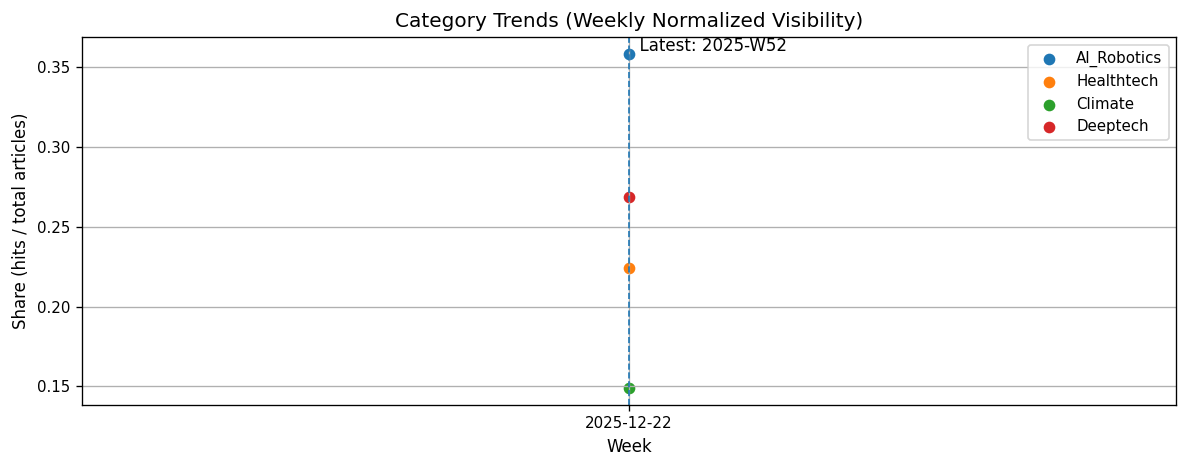


(Info) Only one week available — showing category table for sanity check:


,iso_week_label,category,category_share_ma_3w
0,2025-W52,AI_Robotics,0.358342
1,2025-W52,Healthtech,0.224087
2,2025-W52,Climate,0.149062
3,2025-W52,Deeptech,0.268509


In [16]:
# ============================================================
# Cell 8 — Plot 1: Category Trends (robust for 1-week data)
# ============================================================

# This plot shows normalized weekly visibility (share) at the category level.
# It is designed to render even when only a single week of data is available.

USE_SMOOTHED = True
y_col = "category_share_ma_3w" if USE_SMOOTHED else "category_share"

# Pick source dataframe
plot_df = metrics_cat_opt.copy() if USE_SMOOTHED else metrics_cat_week.copy()

# Required columns
req = {"week_start", "iso_week_label", "category", y_col}
missing = req - set(plot_df.columns)
if missing:
    raise ValueError(f"Missing required columns for category plot: {missing}")

# Category ordering (fixed for consistent reporting)
CATEGORY_ORDER = ["AI_Robotics", "Healthtech", "Climate", "Deeptech"]

# ---- Ensure all categories exist for each week (fill missing with 0) ----
weeks = sorted(plot_df["week_start"].dropna().unique())
if len(weeks) == 0:
    raise ValueError("No week_start values found for plotting.")

grid = pd.MultiIndex.from_product([weeks, CATEGORY_ORDER], names=["week_start", "category"]).to_frame(index=False)

# Keep one iso_week_label per week_start (take the first)
week_labels = (
    plot_df[["week_start", "iso_week_label"]]
    .drop_duplicates(subset=["week_start"])
    .sort_values("week_start")
)

grid = grid.merge(week_labels, on="week_start", how="left")

plot_df = grid.merge(
    plot_df[["week_start", "category", y_col]],
    on=["week_start", "category"],
    how="left"
)

plot_df[y_col] = plot_df[y_col].fillna(0.0)
plot_df["category"] = pd.Categorical(plot_df["category"], categories=CATEGORY_ORDER, ordered=True)
plot_df = plot_df.sort_values(["category", "week_start"])

# ---- Plot ----
n_weeks = plot_df["week_start"].nunique()
fig, ax = plt.subplots(figsize=(10, 4))

for cat in CATEGORY_ORDER:
    df_cat = plot_df[plot_df["category"] == cat]
    x = df_cat["week_start"]
    y = df_cat[y_col]

    if n_weeks >= 2:
        ax.plot(x, y, marker="o", label=cat)
    else:
        # Single-week: show a point (and optional short horizontal tick)
        ax.scatter(x, y, label=cat)
        ax.plot(x, y, linewidth=0.5)  # minimal stroke so legend matches line style

ax.set_title("Category Trends (Weekly Normalized Visibility)")
ax.set_xlabel("Week")
ax.set_ylabel("Share (hits / total articles)")

# ---- Axis formatting (robust) ----
if n_weeks >= 3:
    apply_weekly_date_axis(ax)
else:
    # For 1–2 points, keep ticks simple and readable
    ax.set_xticks(sorted(plot_df["week_start"].unique()))
    ax.set_xticklabels([pd.Timestamp(t).strftime("%Y-%m-%d") for t in sorted(plot_df["week_start"].unique())], rotation=0)

ax.legend(loc="best")

# Annotate latest week label
latest_week = max(weeks)
latest_label = week_labels.loc[week_labels["week_start"] == latest_week, "iso_week_label"].iloc[0]
ax.axvline(latest_week, linestyle="--", linewidth=1)
ax.text(latest_week, ax.get_ylim()[1], f"  Latest: {latest_label}", va="top")

plt.show()

# Optional: show the underlying table for 1-week runs (useful sanity check)
if n_weeks == 1:
    print("\n(Info) Only one week available — showing category table for sanity check:")
    display(
        plot_df[plot_df["week_start"] == latest_week][["iso_week_label", "category", y_col]]
        .sort_values("category")
        .reset_index(drop=True)
    )


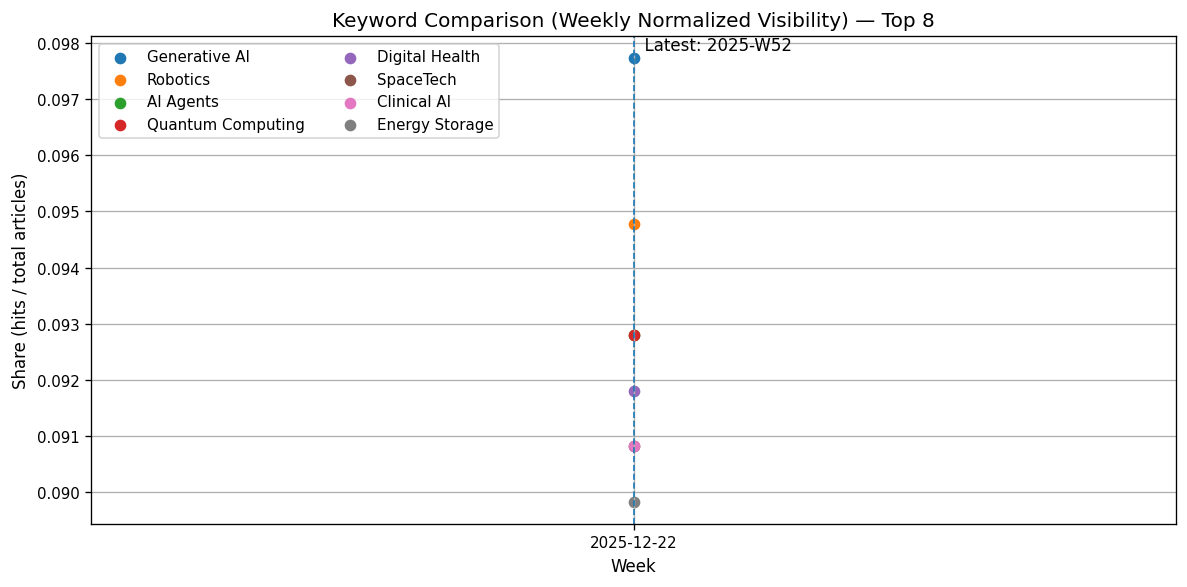


Latest-week keyword ranking:


,iso_week_label,keyword_id,canonical,category,value
0,2025-W52,generative_ai,Generative AI,AI_Robotics,0.097730
1,2025-W52,robotics,Robotics,AI_Robotics,0.094768
2,2025-W52,ai_agents,AI Agents,AI_Robotics,0.092794
3,2025-W52,quantum_computing,Quantum Computing,Deeptech,0.092794
4,2025-W52,digital_health,Digital Health,Healthtech,0.091807
5,2025-W52,spacetech,SpaceTech,Deeptech,0.090819
6,2025-W52,clinical_ai,Clinical AI,Healthtech,0.090819
7,2025-W52,energy_storage,Energy Storage,Climate,0.089832
8,2025-W52,edge_ai,Edge AI,AI_Robotics,0.073050
9,2025-W52,advanced_materials,Advanced Materials,Deeptech,0.065153


In [17]:
# ============================================================
# Cell 9 — Plot 2: Keyword Comparison (robust for 1-week data)
# ============================================================

# This plot compares normalized weekly visibility (share) across the 15 keywords.
# It is designed to render even when only a single week of data is available.
#
# Practical note:
# - Plotting 15 lines can be noisy. We therefore support:
#   (A) plotting all keywords, or
#   (B) plotting Top N keywords + (optional) "Others" (not used by default here)

USE_SMOOTHED = True
y_col = "share_ma_3w" if USE_SMOOTHED else "share"

# Use optional metrics when smoothing is enabled
plot_df = metrics_opt.copy() if USE_SMOOTHED else metrics_kw_week.copy()

req = {"week_start", "iso_week_label", "keyword_id", "canonical", "category", y_col}
missing = req - set(plot_df.columns)
if missing:
    raise ValueError(f"Missing required columns for keyword comparison plot: {missing}")

# Fixed keyword order for consistent reporting (based on dictionary)
KEYWORD_ORDER = (
    keywords_df[["keyword_id", "canonical", "category"]]
    .sort_values(["category", "canonical"])
    ["keyword_id"]
    .tolist()
)

# ---- Ensure all keywords exist for each week (fill missing with 0) ----
weeks = sorted(plot_df["week_start"].dropna().unique())
if len(weeks) == 0:
    raise ValueError("No week_start values found for plotting.")

grid = pd.MultiIndex.from_product([weeks, KEYWORD_ORDER], names=["week_start", "keyword_id"]).to_frame(index=False)

# Keep one iso_week_label per week_start
week_labels = (
    plot_df[["week_start", "iso_week_label"]]
    .drop_duplicates(subset=["week_start"])
    .sort_values("week_start")
)

grid = grid.merge(week_labels, on="week_start", how="left")

# Join keyword meta (canonical/category)
grid = grid.merge(
    keywords_df[["keyword_id", "canonical", "category"]],
    on="keyword_id",
    how="left"
)

# Join values
plot_df = grid.merge(
    plot_df[["week_start", "keyword_id", y_col]],
    on=["week_start", "keyword_id"],
    how="left"
)

plot_df[y_col] = plot_df[y_col].fillna(0.0)

# Decide whether to plot all 15 or top N
n_weeks = len(weeks)
PLOT_MODE = "topN"  # "all" or "topN"
TOP_N = 8

latest_week = max(weeks)
latest_label = week_labels.loc[week_labels["week_start"] == latest_week, "iso_week_label"].iloc[0]

if PLOT_MODE == "topN":
    # Pick top keywords by latest-week value
    latest_values = (
        plot_df[plot_df["week_start"] == latest_week]
        .sort_values(y_col, ascending=False)
        .head(TOP_N)
    )
    selected_ids = latest_values["keyword_id"].tolist()
else:
    selected_ids = KEYWORD_ORDER

selected_df = plot_df[plot_df["keyword_id"].isin(selected_ids)].copy()

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 5))

for kid in selected_ids:
    df_k = selected_df[selected_df["keyword_id"] == kid].sort_values("week_start")
    label = KEYWORD_ID_TO_CANONICAL.get(kid, kid)
    x = df_k["week_start"]
    y = df_k[y_col]

    if n_weeks >= 2:
        ax.plot(x, y, marker="o", label=label)
    else:
        ax.scatter(x, y, label=label)
        ax.plot(x, y, linewidth=0.5)

ax.set_title(f"Keyword Comparison (Weekly Normalized Visibility) — {('Top ' + str(TOP_N)) if PLOT_MODE=='topN' else 'All'}")
ax.set_xlabel("Week")
ax.set_ylabel("Share (hits / total articles)")

# Axis formatting (robust)
if n_weeks >= 3:
    apply_weekly_date_axis(ax)
else:
    ax.set_xticks(sorted(weeks))
    ax.set_xticklabels([pd.Timestamp(t).strftime("%Y-%m-%d") for t in sorted(weeks)], rotation=0)

ax.legend(loc="best", ncol=2)

# Annotate latest week
ax.axvline(latest_week, linestyle="--", linewidth=1)
ax.text(latest_week, ax.get_ylim()[1], f"  Latest: {latest_label}", va="top")

plt.show()

# Optional: show latest-week ranking table (very useful for 1-week runs)
print("\nLatest-week keyword ranking:")
display(
    plot_df[plot_df["week_start"] == latest_week]
    .sort_values(y_col, ascending=False)
    .loc[:, ["iso_week_label", "keyword_id", "canonical", "category", y_col]]
    .rename(columns={y_col: "value"})
    .head(15)
    .reset_index(drop=True)
)


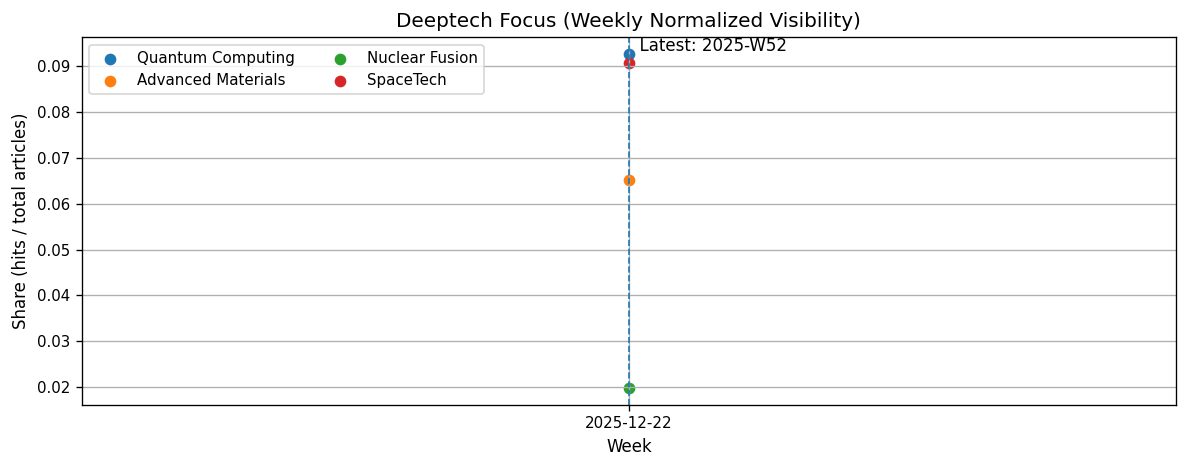


Latest-week Deeptech ranking:


,iso_week_label,keyword_id,canonical,value
0,2025-W52,quantum_computing,Quantum Computing,0.092794
1,2025-W52,spacetech,SpaceTech,0.090819
2,2025-W52,advanced_materials,Advanced Materials,0.065153
3,2025-W52,nuclear_fusion,Nuclear Fusion,0.019743


In [18]:
# ============================================================
# Cell 10 — Plot 3: Deeptech Focus (robust for 1-week data)
# ============================================================

# This plot focuses on the Deeptech / Frontier subset:
# - Quantum Computing
# - Advanced Materials
# - Nuclear Fusion
# - SpaceTech
#
# It is designed to render even when only a single week of data is available.

USE_SMOOTHED = True
y_col = "share_ma_3w" if USE_SMOOTHED else "share"

plot_df = metrics_opt.copy() if USE_SMOOTHED else metrics_kw_week.copy()

req = {"week_start", "iso_week_label", "keyword_id", "canonical", "category", y_col}
missing = req - set(plot_df.columns)
if missing:
    raise ValueError(f"Missing required columns for Deeptech focus plot: {missing}")

# Define Deeptech keyword universe (by keyword_id)
DEEPTECH_KEYWORDS = [
    "quantum_computing",
    "advanced_materials",
    "nuclear_fusion",
    "spacetech",
]

# Filter to deeptech category + selected ids (defensive)
deep_df = plot_df[
    (plot_df["keyword_id"].isin(DEEPTECH_KEYWORDS)) |
    (plot_df["category"].astype(str) == "Deeptech")
].copy()

# If Deeptech keyword_ids differ, fall back to category-only selection
if deep_df.empty:
    deep_df = plot_df[plot_df["category"].astype(str) == "Deeptech"].copy()

# Ensure a stable list of keyword_ids to plot
deep_ids = (
    keywords_df[keywords_df["category"].astype(str) == "Deeptech"]["keyword_id"]
    .tolist()
)

# Prefer the explicit 4, but keep only those present in dictionary
deep_ids = [kid for kid in DEEPTECH_KEYWORDS if kid in set(deep_ids)] or deep_ids

# ---- Ensure all deeptech keywords exist for each week (fill missing with 0) ----
weeks = sorted(deep_df["week_start"].dropna().unique())
if len(weeks) == 0:
    raise ValueError("No week_start values found for Deeptech plotting.")

grid = pd.MultiIndex.from_product([weeks, deep_ids], names=["week_start", "keyword_id"]).to_frame(index=False)

week_labels = (
    deep_df[["week_start", "iso_week_label"]]
    .drop_duplicates(subset=["week_start"])
    .sort_values("week_start")
)

grid = grid.merge(week_labels, on="week_start", how="left")
grid = grid.merge(
    keywords_df[["keyword_id", "canonical", "category"]],
    on="keyword_id",
    how="left"
)

deep_plot = grid.merge(
    deep_df[["week_start", "keyword_id", y_col]],
    on=["week_start", "keyword_id"],
    how="left"
)

deep_plot[y_col] = deep_plot[y_col].fillna(0.0)

# ---- Plot ----
n_weeks = len(weeks)
fig, ax = plt.subplots(figsize=(10, 4))

for kid in deep_ids:
    df_k = deep_plot[deep_plot["keyword_id"] == kid].sort_values("week_start")
    label = KEYWORD_ID_TO_CANONICAL.get(kid, kid)
    x = df_k["week_start"]
    y = df_k[y_col]

    if n_weeks >= 2:
        ax.plot(x, y, marker="o", label=label)
    else:
        ax.scatter(x, y, label=label)
        ax.plot(x, y, linewidth=0.5)

ax.set_title("Deeptech Focus (Weekly Normalized Visibility)")
ax.set_xlabel("Week")
ax.set_ylabel("Share (hits / total articles)")

# Axis formatting (robust)
if n_weeks >= 3:
    apply_weekly_date_axis(ax)
else:
    ax.set_xticks(sorted(weeks))
    ax.set_xticklabels([pd.Timestamp(t).strftime("%Y-%m-%d") for t in sorted(weeks)], rotation=0)

ax.legend(loc="best", ncol=2)

# Latest week annotation
latest_week = max(weeks)
latest_label = week_labels.loc[week_labels["week_start"] == latest_week, "iso_week_label"].iloc[0]
ax.axvline(latest_week, linestyle="--", linewidth=1)
ax.text(latest_week, ax.get_ylim()[1], f"  Latest: {latest_label}", va="top")

plt.show()

# Optional: show deeptech table for the latest week
print("\nLatest-week Deeptech ranking:")
display(
    deep_plot[deep_plot["week_start"] == latest_week]
    .sort_values(y_col, ascending=False)
    .loc[:, ["iso_week_label", "keyword_id", "canonical", y_col]]
    .rename(columns={y_col: "value"})
    .reset_index(drop=True)
)


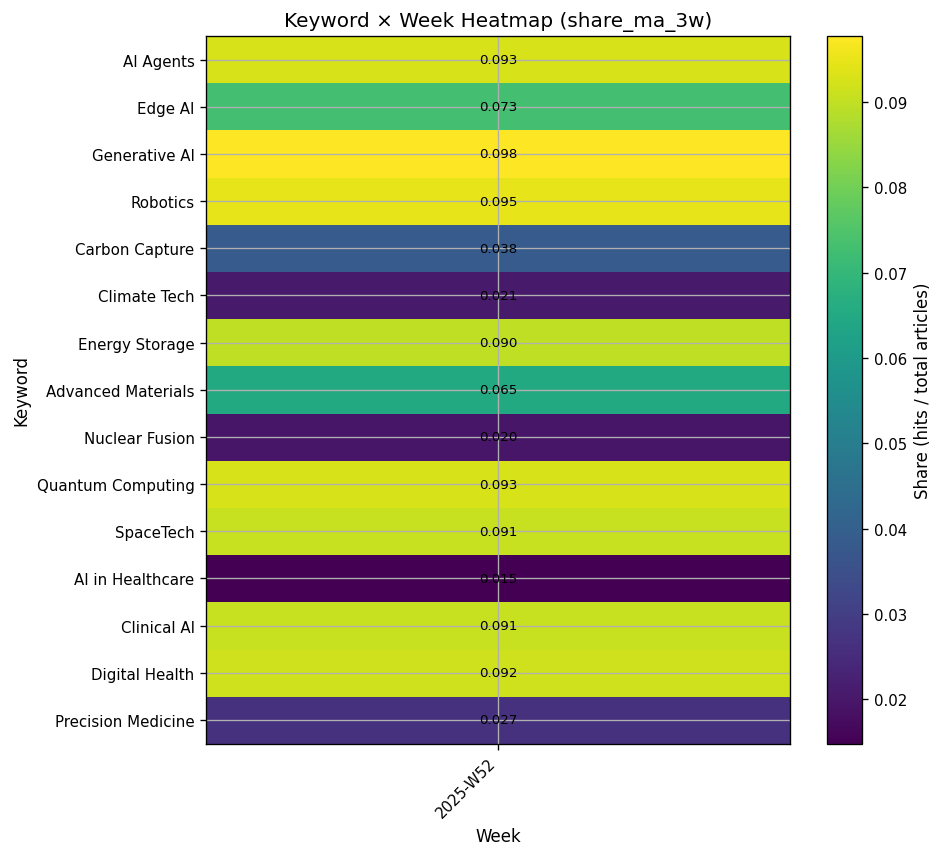


Heatmap table (top rows):


iso_week_label,keyword_id,2025-W52
0,ai_agents,0.092794
1,edge_ai,0.073050
2,generative_ai,0.097730
3,robotics,0.094768
4,carbon_capture,0.038500
5,climate_tech,0.020731
6,energy_storage,0.089832
7,advanced_materials,0.065153
8,nuclear_fusion,0.019743
9,quantum_computing,0.092794


In [19]:
# ============================================================
# Cell 11 — Plot 4: Heatmap (keyword × week)  [matplotlib-only]
# ============================================================

# This heatmap provides a compact "temperature map" of keyword visibility over time.
# Rows:    keywords (15)
# Columns: weeks (week_start / iso_week_label)
# Values:  normalized share (hits / total_articles), optionally smoothed
#
# Designed to render even with only 1 week of data.

USE_SMOOTHED = True
value_col = "share_ma_3w" if USE_SMOOTHED else "share"

src_df = metrics_opt.copy() if USE_SMOOTHED else metrics_kw_week.copy()

req = {"week_start", "iso_week_label", "keyword_id", value_col}
missing = req - set(src_df.columns)
if missing:
    raise ValueError(f"Missing required columns for heatmap: {missing}")

# Stable keyword ordering (use dictionary order)
KEYWORD_ORDER = (
    keywords_df[["keyword_id", "canonical", "category"]]
    .sort_values(["category", "canonical"])
    ["keyword_id"]
    .tolist()
)

# Build pivot (keyword x week)
# Use iso_week_label for column labels; week_start is used for sorting
src_df = src_df.sort_values("week_start")

pivot = (
    src_df.pivot_table(
        index="keyword_id",
        columns="iso_week_label",
        values=value_col,
        aggfunc="mean",
        fill_value=0.0,
    )
    .reindex(KEYWORD_ORDER)
)

# Replace index with canonical labels for readability
row_labels = [KEYWORD_ID_TO_CANONICAL.get(k, k) for k in pivot.index]
col_labels = list(pivot.columns)

heat_values = pivot.values  # 2D array

# ----------------------------
# Plot heatmap
# ----------------------------
fig_w = max(8, 0.7 * len(col_labels) + 3)   # adapt width to number of weeks
fig_h = max(5, 0.35 * len(row_labels) + 2)  # adapt height to number of keywords

fig, ax = plt.subplots(figsize=(fig_w, fig_h))
im = ax.imshow(heat_values, aspect="auto")

ax.set_title(f"Keyword × Week Heatmap ({value_col})")
ax.set_xlabel("Week")
ax.set_ylabel("Keyword")

# Ticks / labels
ax.set_xticks(np.arange(len(col_labels)))
ax.set_xticklabels(col_labels, rotation=45, ha="right")

ax.set_yticks(np.arange(len(row_labels)))
ax.set_yticklabels(row_labels)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Share (hits / total articles)")

# Optional: annotate values when the grid is small (useful for 1–3 weeks)
if len(col_labels) <= 3:
    for i in range(heat_values.shape[0]):
        for j in range(heat_values.shape[1]):
            ax.text(j, i, f"{heat_values[i, j]:.3f}", ha="center", va="center", fontsize=8)

plt.show()

# Optional: show the underlying table for sanity check
print("\nHeatmap table (top rows):")
display(
    pivot.reset_index()
    .rename(columns={"keyword_id": "keyword_id"})
    .head(10)
)


In [20]:
# ============================================================
# Cell 12 — Save Figures (File Naming Rules)
# ============================================================

# This cell saves all figures generated in this notebook using
# a consistent, reproducible naming convention.
#
# Design goals:
# - Filenames encode WHAT / WHEN / HOW
# - Easy to diff across weeks
# - Safe for both local runs and GitHub Actions
#
# Naming convention:
#   {run_week_label}_{plot_id}_{description}.png
#
# Examples:
# - 2025-W52_plot1_category_trends.png
# - 2025-W52_plot2_keyword_comparison.png
# - 2025-W52_plot3_deeptech_focus.png
# - 2025-W52_plot4_keyword_week_heatmap.png

from datetime import datetime

# ----------------------------
# Resolve run_week_label
# ----------------------------
# Prefer iso_week_label from metrics; fall back to current UTC week.
if "iso_week_label" in metrics_kw_week.columns and metrics_kw_week["iso_week_label"].notna().any():
    run_week_label = (
        metrics_kw_week
        .sort_values("week_start")
        .iloc[-1]["iso_week_label"]
    )
else:
    run_week_label = datetime.now(UTC).strftime("%Y-W%V")

print(f"Saving figures for run_week_label = {run_week_label}")

# ----------------------------
# Output directory
# ----------------------------
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ----------------------------
# Helper function
# ----------------------------
def save_current_figure(plot_id: str, description: str) -> Path:
    """
    Save the current matplotlib figure with a standardized filename.
    """
    filename = f"{run_week_label}_{plot_id}_{description}.png"
    path = FIG_DIR / filename
    plt.savefig(path, bbox_inches="tight")
    print(f"✅ Saved figure: {path}")
    return path


# ----------------------------
# Save figures
# ----------------------------
# IMPORTANT:
# - Call this cell *after* each plot cell has been executed.
# - If running all cells sequentially, re-run this cell once per plot,
#   or manually call save_current_figure() at the end of each plot cell.

# Expected plot IDs:
# Plot 1 → "plot1", "category_trends"
# Plot 2 → "plot2", "keyword_comparison"
# Plot 3 → "plot3", "deeptech_focus"
# Plot 4 → "plot4", "keyword_week_heatmap"

# Example usage (uncomment as needed):
# save_current_figure("plot1", "category_trends")
# save_current_figure("plot2", "keyword_comparison")
# save_current_figure("plot3", "deeptech_focus")
# save_current_figure("plot4", "keyword_week_heatmap")

print(
    "\nNote:\n"
    "- Uncomment the save_current_figure(...) calls above after running each plot cell.\n"
    "- This explicit call pattern avoids accidentally overwriting figures when re-running cells."
)


Saving figures for run_week_label = 2025-W52

Note:
- Uncomment the save_current_figure(...) calls above after running each plot cell.
- This explicit call pattern avoids accidentally overwriting figures when re-running cells.


In [21]:
# ============================================================
# Cell 13 — Weekly Insight Stub (Table)
# ============================================================

# This cell produces a lightweight, human-readable summary table for the latest week.
# The table is intended to support:
# - weekly review / memo writing
# - quick identification of movers
# - selection of topics for deeper qualitative analysis
#
# The output here is intentionally simple and explainable.
# No automated interpretation or LLM calls are made at this stage.

# ----------------------------
# Select latest week
# ----------------------------
latest_week = metrics_kw_week["week_start"].max()
latest_label = (
    metrics_kw_week
    .loc[metrics_kw_week["week_start"] == latest_week, "iso_week_label"]
    .iloc[0]
)

print(f"Weekly Insight Stub — {latest_label}")

# ----------------------------
# Base ranking (by normalized share)
# ----------------------------
latest_base = (
    metrics_kw_week[metrics_kw_week["week_start"] == latest_week]
    .sort_values("share", ascending=False)
)

# ----------------------------
# Join optional metrics (if available)
# ----------------------------
if "metrics_opt" in globals():
    latest_opt = metrics_opt[metrics_opt["week_start"] == latest_week]
    latest = latest_base.merge(
        latest_opt[[
            "keyword_id",
            "share_ma_3w",
            "share_wow_delta",
            "share_zscore",
        ]],
        on="keyword_id",
        how="left",
    )
else:
    latest = latest_base.copy()
    latest["share_ma_3w"] = np.nan
    latest["share_wow_delta"] = np.nan
    latest["share_zscore"] = np.nan

# ----------------------------
# Construct insight table
# ----------------------------
insight_cols = [
    "keyword_id",
    "canonical",
    "category",
    "hits",
    "total_articles",
    "share",
    "share_ma_3w",
    "share_wow_delta",
    "share_zscore",
]

insight_table = (
    latest[insight_cols]
    .copy()
    .reset_index(drop=True)
)

# Optional rounding for readability
for col in ["share", "share_ma_3w", "share_wow_delta", "share_zscore"]:
    if col in insight_table.columns:
        insight_table[col] = insight_table[col].astype(float).round(4)

# ----------------------------
# Display
# ----------------------------
display(insight_table)

# ----------------------------
# Suggested manual interpretation guide (comment only)
# ----------------------------
# How to read this table:
# - share: current-week visibility (normalized)
# - share_ma_3w: short-term smoothed trend (directional)
# - share_wow_delta: absolute week-over-week change
# - share_zscore:
#     > 2.0   → unusually hot week for this keyword
#     ~ 0.0   → around historical baseline
#     < -1.5  → unusually cold week
#
# Typical next actions:
# - Investigate top share_zscore keywords (why now?)
# - Compare Deeptech vs AI vs Healthtech temperature
# - Select 1–2 keywords for article-level deep dive


Weekly Insight Stub — 2025-W52


,keyword_id,canonical,category,hits,total_articles,share,share_ma_3w,share_wow_delta,share_zscore
0,generative_ai,Generative AI,AI_Robotics,99,1013,0.0977,0.0977,NaN,0.0
1,robotics,Robotics,AI_Robotics,96,1013,0.0948,0.0948,NaN,0.0
2,ai_agents,AI Agents,AI_Robotics,94,1013,0.0928,0.0928,NaN,0.0
3,quantum_computing,Quantum Computing,Deeptech,94,1013,0.0928,0.0928,NaN,0.0
4,digital_health,Digital Health,Healthtech,93,1013,0.0918,0.0918,NaN,0.0
5,spacetech,SpaceTech,Deeptech,92,1013,0.0908,0.0908,NaN,0.0
6,clinical_ai,Clinical AI,Healthtech,92,1013,0.0908,0.0908,NaN,0.0
7,energy_storage,Energy Storage,Climate,91,1013,0.0898,0.0898,NaN,0.0
8,edge_ai,Edge AI,AI_Robotics,74,1013,0.0731,0.0731,NaN,0.0
9,advanced_materials,Advanced Materials,Deeptech,66,1013,0.0652,0.0652,NaN,0.0
